<a href="https://colab.research.google.com/github/Ganesh-Esc/Deep-Learning---Autoencoders/blob/main/Autoencoder_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Autoencoder with Python__

## Author

<a href="https://www.linkedin.com/in/ganesh-kommana/" target="_blank">Ganesh Kommana</a>

In this lab, we will first review how to build a shallow autoencoder using the Keras functional API and the Model subclassing. Then, we will review some applications of autoencoders such as image denoising and image compression. Lastly, we will use what we have learned in the later sections to build deeper autoencoders.

As the figure shows below, when used on images, autoencoders can not only return the reconstructed image but also return a compressed version of it. The compressed data is very useful as it achieves the goal of dimensionality reduction while retaining meaningful information from the image. We will soon dive deep into how different types of autoencoders help us realize all these goals!

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/intro_pic.png" width="65%" style="vertical-align:middle;margin:30px 0px"></center>

Image credits to [Yifei Zhang](https://www.semanticscholar.org/paper/A-Better-Autoencoder-for-Image%3A-Convolutional-Zhang/b1786e74e233ac21f503f59d03f6af19a3699024?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01)


## Objectives

After completing this lab, you will be able to:

 - Apply Autoencoders to real world problems
 - Implement different autoencoder architecture
 - Train different autoencoders


### Installing Required Libraries

In [2]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install opencv-python


### Importing Required Libraries

In [3]:
import os
import copy


import numpy as np
from numpy.core.fromnumeric import reshape

import tensorflow as tf

import keras
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D
from keras.models import Model


from keras.layers import Conv2D
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

/tmp/ipython-input-2008801106.py:6: DeprecationWarning: numpy.core.fromnumeric is deprecated and has been renamed to numpy._core.fromnumeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.fromnumeric.reshape.
  from numpy.core.fromnumeric import reshape


### Defining Helper Functions

In [4]:
def plot_images(top,bottom,start=0,stop=5,reshape_x=(28,28),reshape_xhat=(28,28)):

    '''
    this function plots images from the start index to the stop index from two datasets

    '''

    n_samples=stop-start

    for i,img_index in enumerate(range(start,stop)):

        # Display original
        ax = plt.subplot(2, n_samples, i + 1)
        plt.imshow(top[img_index].reshape(reshape_x[0], reshape_x[1]), cmap="gray")

        if i==n_samples//2:
            plt.title("original images")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(bottom[img_index].reshape(reshape_xhat[0], reshape_xhat[1]), cmap="gray")


        if i==n_samples//2:
            plt.title("encoded images")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [5]:
def graph_history(history, title='Log Loss and Accuracy over iterations'):

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(title)
    N_plots=len(history.history.keys())
    color_list=['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w','bx','rx']
    for i,(key, items) in enumerate(history.history.items()):
        ax = fig.add_subplot(1, N_plots, i+1)
        ax.plot(items,c=color_list[i])
        ax.grid(True)
        ax.set(xlabel='iterations', title=key)

In [6]:
def add_noise(x_train, x_test, noise_factor = 0.3):
    '''
    this function adds random values from a normal distribution as noises to the data

    returns the noisy datasets

    '''
    noise_factor = 0.3
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.).numpy()
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.).numpy()

    return x_train_noisy,x_test_noisy

In [7]:
def plot_code(h, y, numbers=[0,1,2,3,4,5,6,7,8,9], scale=[1,1,1]):
    """
    number: list of classes to be plotted
    scale: scale activations to plot better

    """
    h=h.numpy()
    color_list=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink','darkorange','lime']
    logic_array =np.zeros(len(y), dtype=bool)

    fig=plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for num, color in zip(numbers, color_list):
        logic_array = (y==num)
        plt.scatter(scale[0]*h[logic_array,0],scale[1]*h[logic_array,1],scale[2]*h[logic_array,2],c=color, label=num)

    plt.title("3D output of encoder, colored by digits")
    plt.legend(loc=[1.1,0.3])
    plt.show()

In [8]:
def avg(shape, dtype=None):
    grad = np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
        ]).reshape((3, 3, 1, 1))/9

    assert grad.shape == shape
    return tf.Variable(grad, dtype='float32')

a_conv = layers.Conv2D(filters=1,
                       kernel_size=3,
                       kernel_initializer=avg,
                       strides=1,
                       padding='same')

In [67]:
def display_auto(Xiter,n=1,B=1):

    """
    This function displays the ouput of an autoencder
    Returns:  void images
    Args:
    Xiter:image_dataset_from_directory object converted to iterator
    n:sample within batch
    B: batch number
    """

    for b in range(B):
        x = next(Xiter)

        plt.imshow(x[0].numpy()[n,:,:,0],cmap="gray")
        plt.title("input image from dataset")
        plt.show()
        # Removed the second plot as the dataset is not currently yielding a second image for comparison
        # plt.imshow(x[1].numpy()[n,:,:,0],cmap="gray")
        # plt.title("encoded images")
        # plt.show()

## Introduction


An autoencoder is a neural network that minimizes the difference between the input and the output. The network has two parts: the **encoder** part which outputs the code $\textbf{Z}$ using the message $\textbf{X}$ such that $\textbf{Z} = \textbf{E(X)}$. The code $\textbf{Z}$ is then passed along to reconstruct the message $\textbf{X}$, and the **decoder** is the second part does the reconstruction, which produces $\hat{\textbf{X}}= \textbf{D(Z)}$.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/flow.png" width="60%" style="vertical-align:middle;margin:50px 0px"></center>

In general $\textbf{D(E(X))} = \hat{\textbf{X}}$ such that $\hat{\textbf{X}}$ is an approximation of $\textbf{X}$. This forces the model to learn useful properties of the data, which would be useful in applications such as image enhancement and outlier detection.


## Shallow Autoencoders

They are the simplest autoencoders, which typically consist of a one-layer encoder followed by a one-layer decoder. The encoder can have an activation function or not. Similarly, the decoder can have a real output or a bounded output, for example, between 0 and 1.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/shallow_model.png" width="45%" style="vertical-align:middle;margin:30px 0px"></center>


Let's use the MNIST data from `keras.datasets` as a beginning example:


In [10]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) =keras.datasets.mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(10000, 784)


Here we introduce two ways to build shallow autoencoders in Keras, one is using the **Keras functional API**, and the other one is **subclassing the Keras Model class**.

### Autoencoders using the Functional API

The functional interface **uses the layers as functions**, taking a tensor as input and outputting a tensor instead of stacking layers on top of one another (like the Sequential class in Keras). By doing so, your way of building up the model layers is **more flexible** in the sense that your **model can take inputs from multiple paths and then add the tensors together at some point**.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/functional_API.png" width="30%" style="vertical-align:middle;margin:0px 0px"></center>


We create an input object, ```input_img```, which allows us to input tensors into our model object; as each image is 784 dimensional, the input shape is (784, ).

In [11]:
input_img=Input(shape=(784,))

We create an encoder layer using a Dense layer and the Relu activation. The encoding dimension will be the output dimension of the Dense layer. We also call the object ``input_img`` to specify the input of the encoding layer.

In [12]:
encoding_dim=36
encoder = Dense(encoding_dim, activation='relu')(input_img)

The output dimension of the image. We create a decoding layer using a Dense layer; as the image values are between 0 to 1, we use the sigmoid activation for the output. We also call the object ```encoder``` to specify the input of the decoding layer, and this layer can also be linear.

In [13]:
decoder=Dense(784,activation='sigmoid')(encoder)

We combine the encoder and decoder using the model class for training and inference, specifying the input ```input_img``` and output  ```decoder```


In [14]:
autoencoder =Model(input_img, decoder)

We compile the model using the adam optimizer and the cross entropy loss, and you can also use the mean square error as the loss function.

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

We now fit the model; if you recall, in the supervised case, the first two inputs are (y_true, y_pred), where y_true are the ground truth values, and y_pred is the predicted value. As the autoencoder tries to replicate the input, y_true and y_pred are the input x, similarly for the validation data. The rest of the parameters behave similarly.

In [16]:
history=autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.3795 - val_loss: 0.1842
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1746 - val_loss: 0.1487
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1445 - val_loss: 0.1289
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.1270 - val_loss: 0.1163
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1153 - val_loss: 0.1077
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1074 - val_loss: 0.1017
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1018 - val_loss: 0.0975
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0979 - val_loss: 0.0946
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0951 - val_loss: 0.0925
Epoch 10/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0933 - val_loss: 0.0909
Epoch 11/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0918 - val_loss: 0.0901
Epoch 12/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 

We can plot the loss for each iteration:

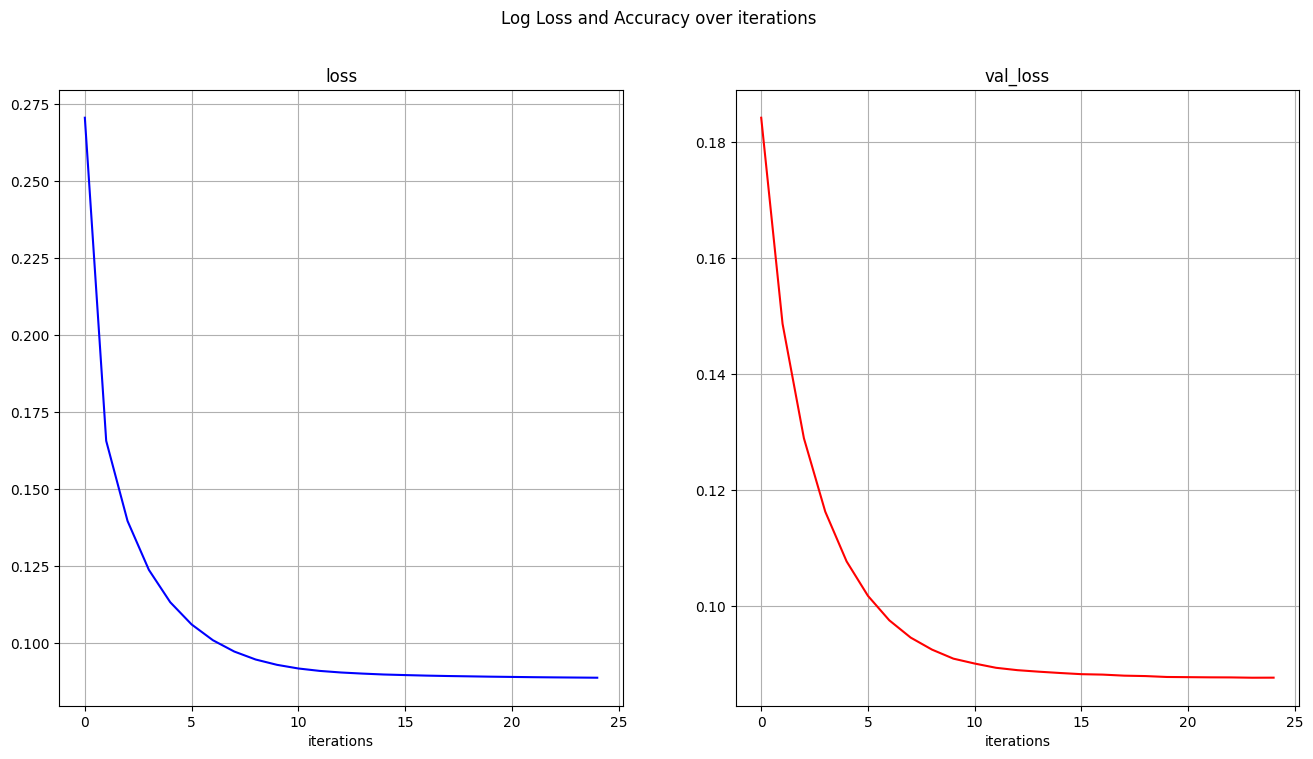

In [17]:
graph_history(history, title='Log Loss and Accuracy over iterations')

We see that the loss is lower; furthermore, the training data is similar to the testing data. This suggests the Autoencoder does well at modeling the data.

We can make a prediction using the method ```predict```

In [18]:
xhat=autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


We can compare the output of the autoencoder with the original input. We see they are pretty similar:

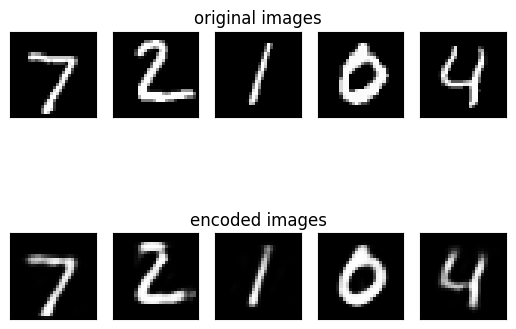

In [19]:
plot_images(x_test,xhat,start=0,stop=5)

### Autoencoders using Model Subclassing

Keras also provides an object-oriented approach to creating models, where we can subclass the `keras.Model` class to have our own class of Autoencoder models inherit or override the properties and methods of `keras.Model`. This subclassing approach **helps with reusability and allows you to represent the models you want to create as classes**.

It's easier to use model subclassing to build autoencoders with the following boilerplate. Let's create an ```Autoencoder``` class using the `Model` class from `keras.models` as the parent class.

In [20]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Dense(latent_dim, activation='relu')
        self.decoder = Dense(784, activation='sigmoid')

    def call(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

```latent_dim``` is the size of the input, and the encoder is  given by

```encoder = tf.keras.Sequential([layers.Dense(latent_dim, activation='relu')])```

The decoder is given by:

```decoder = tf.keras.Sequential([layers.Dense(784, activation='sigmoid')])```

The method ```call``` will make a prediction and will be called when the method ```predict``` is called.


With subclassing, we can now create an ```autoencoder``` instance and the only parameter that needs to be specified is the ```encoding_dim```.

In [21]:
encoding_dim=36
autoencoder = Autoencoder(encoding_dim)

The `autoencoder` instance created will not only have the attributes and methods defined within the `autoencoder` class but also inherits all the attributes of the `Model` class.

All the steps are the same as above to fit the model and make a prediction:

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3815 - val_loss: 0.1848
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1745 - val_loss: 0.1480
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1440 - val_loss: 0.1289
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1267 - val_loss: 0.1160
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1149 - val_loss: 0.1073
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1070 - val_loss: 0.1013
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1014 - val_loss: 0.0970
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0975 - val_loss: 0.0940
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0946 - val_loss: 0.0920
Epoch 10/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0929 - val_loss: 0.0907
Epoch 11/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0916 - val_loss: 0.0899
Epoch 12/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 

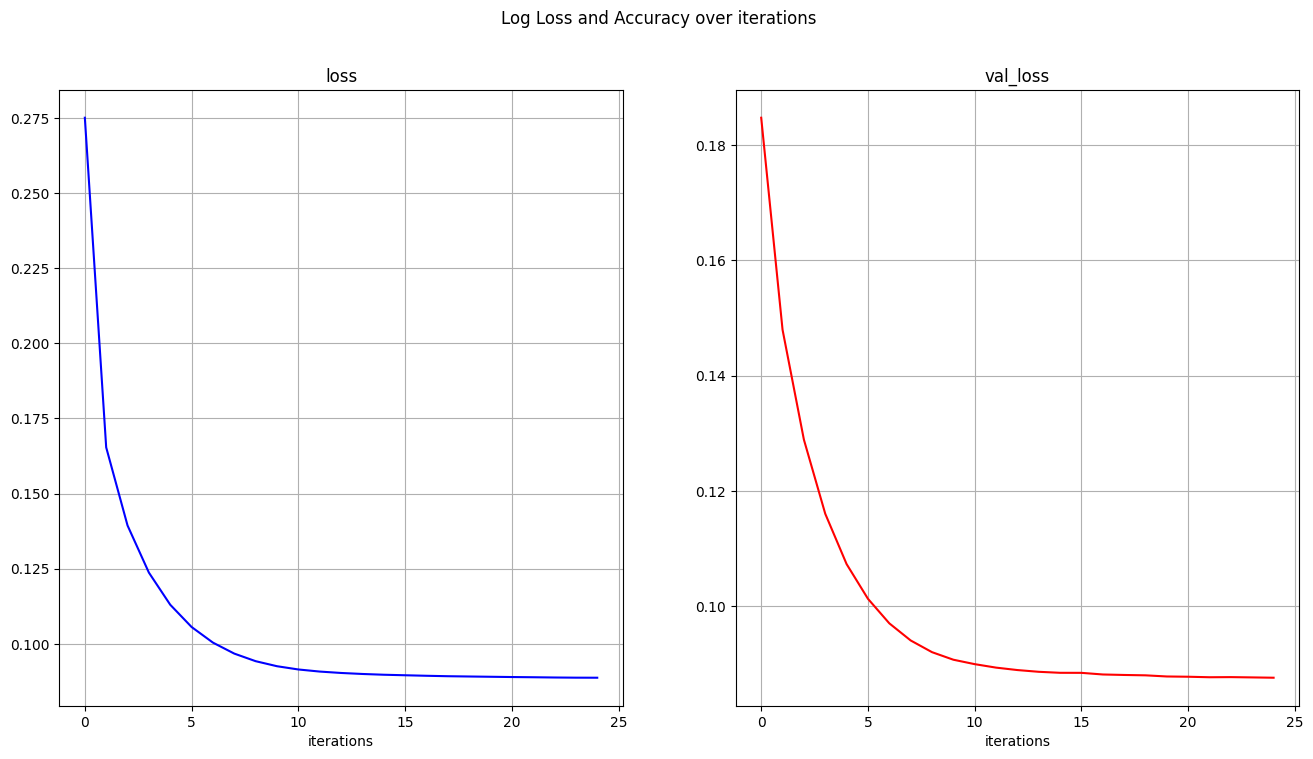

In [22]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(x_train, x_train,epochs=25,batch_size=256,shuffle=True,validation_data=(x_test, x_test))
graph_history(history, title='Log Loss and Accuracy over iterations')

Let's compare the images reconstructed by the trained autoencoder and the original image:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


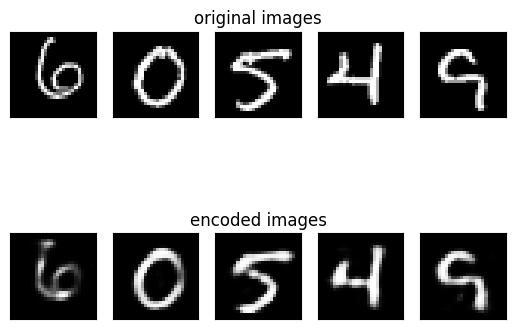

In [23]:
xhat=autoencoder.predict(x_test)
plot_images(x_test,xhat,start=100,stop=105)

We can also generate the output of the encoder by calling the method ```encoder```, which returns the activation of the encoder layer:

In [24]:
h=autoencoder.encoder(x_test)
h.shape

TensorShape([10000, 36])

Since the output dimension of the `encoder` layer is 36, we will need to reshape it to $6\times 6$ in order to plot it as images:

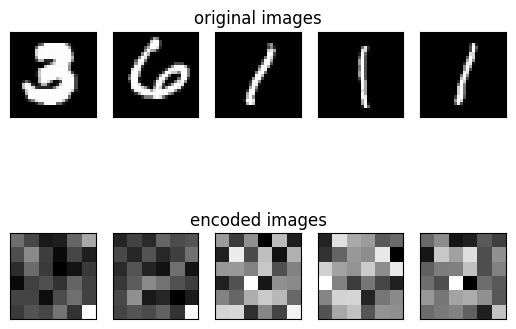

In [25]:
plot_images(x_test, h.numpy(),start=200,stop=205,reshape_x=(28,28),reshape_xhat=(6,6))

Should you use the Keras functional API to create a new model, or just subclass the Model class directly? In general, the functional API is higher-level, easier, and safer, and has a number of features that subclassed models do not support.

However, Model subclassing provides greater flexibility when building models that are not easily expressible as directed acyclic graphs of layers. For example, you could not implement a Tree-RNN with the functional API and would have to subclass the Model directly.

As a last note, choosing between the functional API or Model subclassing isn't a binary decision that restricts you into one category of models. **All models in the `tf.keras` API can interact with each other, whether they're Sequential models, functional models, or subclassed models that are written from scratch!**

Now you know how an autoencoder is constructed and how it works, let's see some real-world applications of autoencoders!


## Applications of Autoencoders


### Anomaly Detection with Autoencoders
Due to the autoencoder architecture (encoder + decoder), autoencoders are forced to learn representations of the images. As a result, only data samples with a similar distribution can be reconstructed with fidelity. This means a high reconstruction loss can be interpreted and used as a method to detect anomalous samples within the data.

Consider the last example. We can find anomalies of the data as follows:

First, we calculate the loss between the predicted samples and the original data. Samples reconstructed with the highest error values (losses) are the anomalies.

We caculate the loss for each of the samples:

In [26]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
loss=[bce(x, x_s).numpy() for x, x_s in zip (x_test,xhat)]

Let's sort the losses with **np.argsort** and then use **np.flip** to flip the order of the indexes so that the losses are sorted in descending order:

In [28]:
indexs=np.flip(np.argsort(loss))

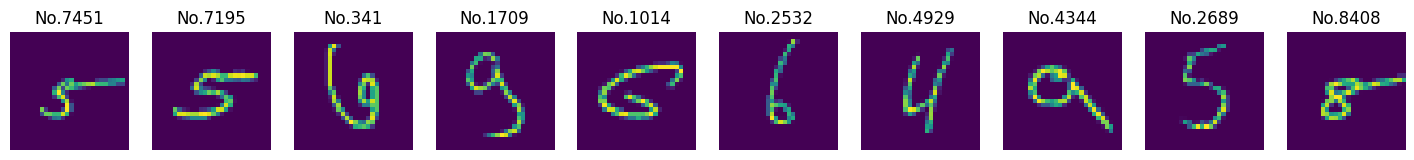

In [29]:
plt.figure(figsize=(18,3))
for i, index in enumerate(indexs[0:10]):

    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[index].reshape(28,28))
    plt.title(f"No.{index}")
    plt.axis("off")

### Denoising Autoencoders

We can also use Autoencoders for denoising. The following figure illustrates what we would like a denoising autoencoder to achieve:

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/denoising.png" width="40%" style="vertical-align:middle;margin:15px 0px"></center>


Let's first add some artificial noises to our digit dataset using the helper function **add_noise**.


In [30]:
x_train_noisy,x_test_noisy= add_noise(x_train, x_test,noise_factor = 0.4)

We can display the training images before and after adding the noises:

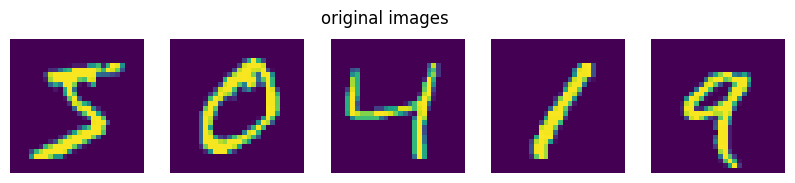

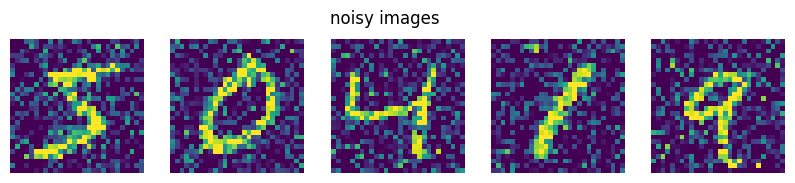

In [31]:
fig1 = plt.figure(figsize=(10,2))
fig1.suptitle("original images")
fig2 = plt.figure(figsize=(10,2))
fig2.suptitle("noisy images")

for i, img_index in enumerate(range(5)):
    ax1 = fig1.add_subplot(1, 5, i+1)
    ax1.imshow(x_train[img_index].reshape((28,28)))
    ax1.axis("off")
    ax2 = fig2.add_subplot(1, 5, i+1)
    ax2.imshow(x_train_noisy[img_index].reshape((28,28)))
    ax2.axis("off")

One way to build a **denoising Autoencoder** is to make the encoding dimension larger than the input dimension; Here, we create an ```autoencoder``` object with an encoding dimension **two times** the input dimension:


In [32]:
encoding_dim=2*x_test.shape[1]
autoencoder = Autoencoder(encoding_dim)

We fit the model, for the fit method (y_true, y_pred), is the noisy data $x_{noisy}$ is the ground truth values, and y_pred is x_train the regular data $x$. The assumption is that where $x_{noisy}$ is a copy of $x$ with some form of noise. Training forces the encoder and decoder to learn the structure of the data implicitly.


Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.2152 - val_loss: 0.0960
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0936 - val_loss: 0.0876
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 0.0869 - val_loss: 0.0851
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0844 - val_loss: 0.0838
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 0.0831 - val_loss: 0.0834
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0819 - val_loss: 0.0824
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - loss: 0.0811 - val_loss: 0.0817
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0806 - val_loss: 0.0815
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0799 - val_loss: 0.0812
Epoch 10/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - loss: 0.0795 - val_loss: 0.0811
Epoch 11/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - loss: 0.0791 - val_loss: 0.0808
Epoch 12/25
235/235 ━━━━━━━━━

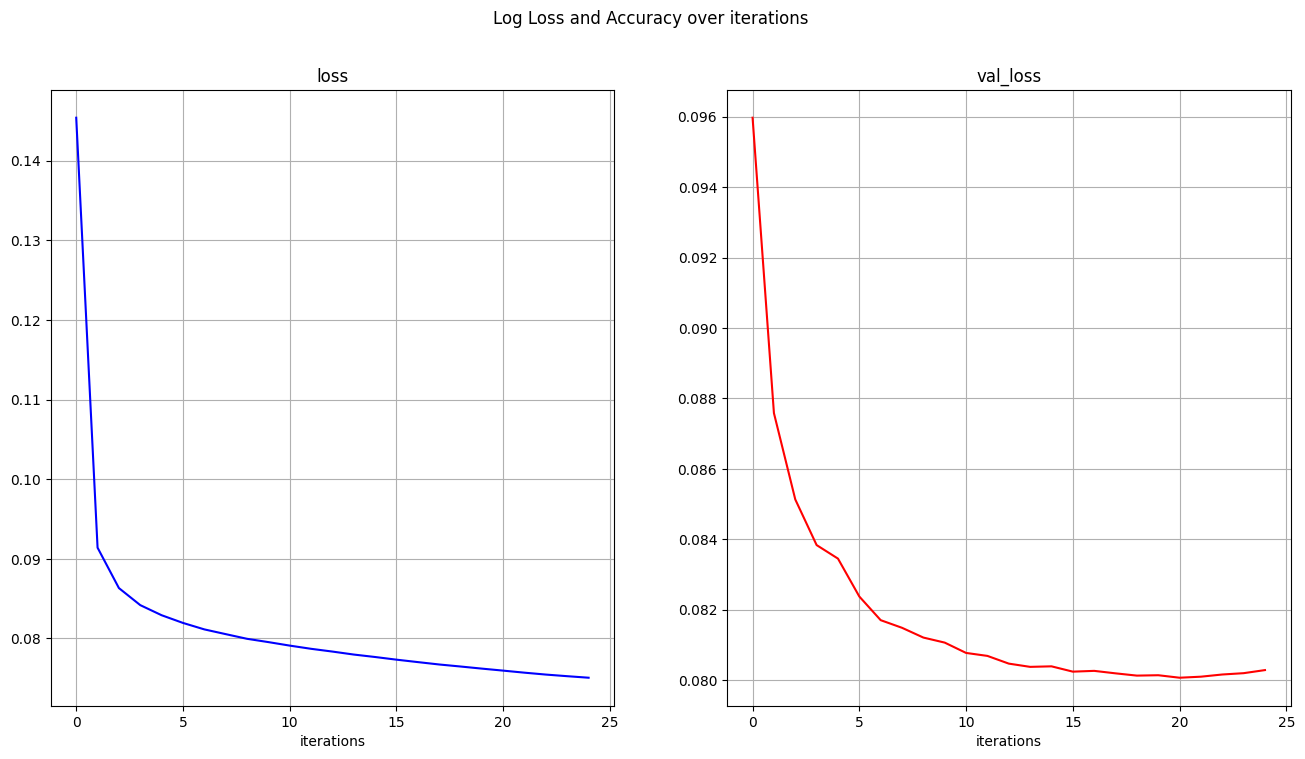

In [33]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(x_train_noisy , x_train,epochs=25,batch_size=256,shuffle=True,validation_data=(x_test_noisy, x_test))
graph_history(history, title='Log Loss and Accuracy over iterations')
xhat=autoencoder.predict(x_test)

Now we plot the images, and we can see that most of the noises are gone:
  

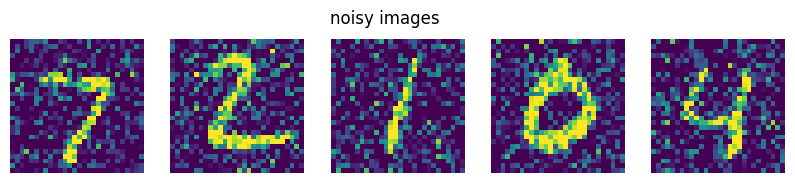

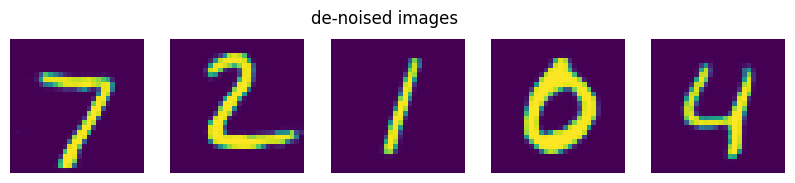

In [34]:
fig1 = plt.figure(figsize=(10,2))
fig1.suptitle("noisy images")
fig2 = plt.figure(figsize=(10,2))
fig2.suptitle("de-noised images")

for i, img_index in enumerate(range(5)):
    ax1 = fig1.add_subplot(1, 5, i+1)
    ax1.imshow(x_test_noisy[img_index].reshape((28,28)))
    ax1.axis("off")
    ax2 = fig2.add_subplot(1, 5, i+1)
    ax2.imshow(xhat[img_index].reshape((28,28)))
    ax2.axis("off")

### Test 1
In this test, you will use the encoder part of an Autoencoder for low-dimensional data visualization.

- Create an autocoder using the class `Autoencoder`, with latent dimension of 3;
- Fit the autoencoder model using the training set `x_train` and validate using the test set `x_test`;
- Apply the `.encoder` method of the autoencoder on the test set `x_test`;
- Display the output using the **plot_code** helper function.


In [35]:
autoencoder = Autoencoder(3)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
h=autoencoder.encoder(x_test)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4974 - val_loss: 0.2766
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2719 - val_loss: 0.2510
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2464 - val_loss: 0.2361
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2353 - val_loss: 0.2317
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2315 - val_loss: 0.2292
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2294 - val_loss: 0.2273
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2277 - val_loss: 0.2258
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2259 - val_loss: 0.2245
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2251 - val_loss: 0.2233
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2243 - val_loss: 0.2225
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2232 - val_loss: 0.2217
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/s

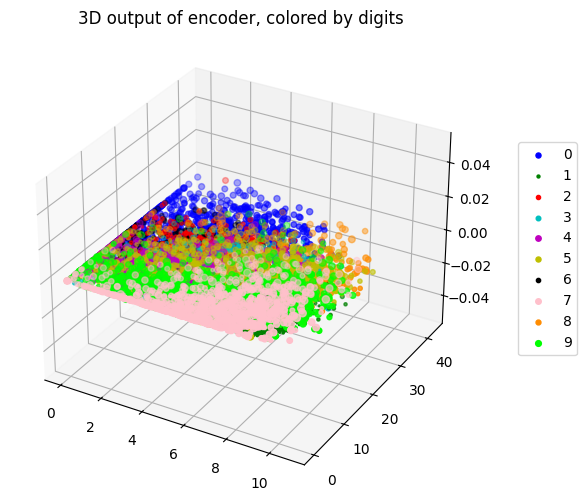

In [36]:
plot_code(h,y_test)

### Test 2

In this exercise, you will work with a different dataset, which is the fashion MNIST dataset downloaded from Keras. You will use an autoencoder to try to reconstruct the images and analyze the results.


In [37]:
(x_train, y_train), (x_test,y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)


Let's flatten the training and validation data and pass it to the Autoencoder:

In [38]:
x_temp=layers.Flatten()(x_train)
x_temp_test=layers.Flatten()(x_test)
x_temp.shape, x_temp_test.shape

(TensorShape([60000, 784]), TensorShape([10000, 784]))

In [39]:
encoding_dim=3
autoencoder = Autoencoder(encoding_dim)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=autoencoder.fit(x_temp,x_temp,epochs=25,batch_size=256,shuffle=True,validation_data=(x_temp_test,x_temp_test))

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.5875 - val_loss: 0.4136
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4036 - val_loss: 0.3924
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3889 - val_loss: 0.3851
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3827 - val_loss: 0.3805
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3785 - val_loss: 0.3770
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3746 - val_loss: 0.3741
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3712 - val_loss: 0.3717
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3698 - val_loss: 0.3694
Epoch 9/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3674 - val_loss: 0.3676
Epoch 10/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3664 - val_loss: 0.3659
Epoch 11/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3636 - val_loss: 0.3645
Epoch 12/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/

Looking at the output, we see the autoencoder can't reconstruct the data very well as it's too complex; Therefore, we need a better approach to represent more complex data.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


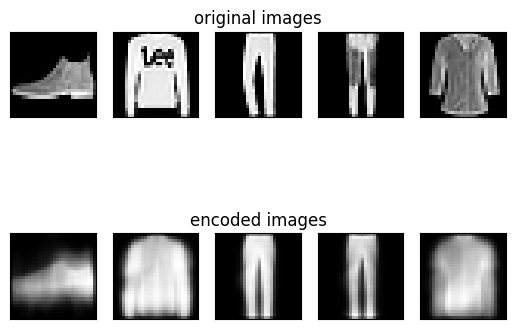

In [40]:
xhat=autoencoder.predict(x_temp_test)
plot_images(x_test,xhat,start=0,stop=5)

## Deep Autoencoders

Like deep neural networks, adding more layers to the encoder and decoder will grant your autoencoders more representational power, allowing you to solve increasingly complex problems. For example, the reconstructed images of the fashion MNIST dataset plotted above did not retain enough features of the original images, so people will instantly recognize a shoe by looking at the first reconstructed image. Analogous to the fact that deep neural networks can learn and extract more complex features from the data than shallow neural networks, a deep autoencoder will also be able to do a better job in tasks that involve complex data than shallow autoencoders.

Let's create a deep autoencoder class, analogous to creating a deep neural network:


In [41]:
class Deep_Autoencoder (Model):
    def __init__(self, latent_dim_1, latent_dim_2):
        super(Deep_Autoencoder, self).__init__()
        self.latent_dim_1= latent_dim_1
        self.latent_dim_1= latent_dim_2
        self.encoder = Sequential([layers.Flatten(),Dense(latent_dim_1, activation='relu'),Dense(latent_dim_2, activation='relu')])
        self.decoder = tf.keras.Sequential([Dense(latent_dim_1, activation='relu'), Dense(784, activation='sigmoid'), Reshape((28, 28))])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

We have the encoder:

```encoder = Sequential([layers.Flatten(),Dense(latent_dim_1, activation='relu'),Dense(latent_dim_2, activation='relu')])```

We add a flattening layer for convenience as we will input rectangular image tensors. The encoder consists of two linear layers with Relu activations. Each layer, in this case, gets consistently smaller.

We have the decoder:

```decoder = tf.keras.Sequential([ Dense(latent_dim_1, activation='relu'),Dense(784, activation='sigmoid'),Reshape((28, 28))])```

which consists of two linear layers. The first layer has a Relu activation; the second layer has a sigmoid activation. For convenience, we add a layer to reshape the output to a rectangular image.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/deep_ae.png" width="70%" style="vertical-align:middle;margin:15px 0px"></center>

By doing so, we create a deep autoencoder object; We set the output shape of each layer smaller and smaller until the latent dimension reaches three. Let's train the model.


In [42]:
latent_dim_1 =128
latent_dim_2=3
deep_autoencoder=Deep_Autoencoder(latent_dim_1=latent_dim_1,latent_dim_2=latent_dim_2)


deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history=deep_autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.4849 - val_loss: 0.3531
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3450 - val_loss: 0.3330
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.3290 - val_loss: 0.3261
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3230 - val_loss: 0.3227
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3199 - val_loss: 0.3211
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3190 - val_loss: 0.3199
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3175 - val_loss: 0.3190
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3158 - val_loss: 0.3184
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.3158 - val_loss: 0.3176
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3153 - val_loss: 0.3172
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3155 - val_loss: 0.3168
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

We plot the output; we can see the reconstructed images look similar to the original images; this is even after the dimension has been reduced to three in the bottleneck.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


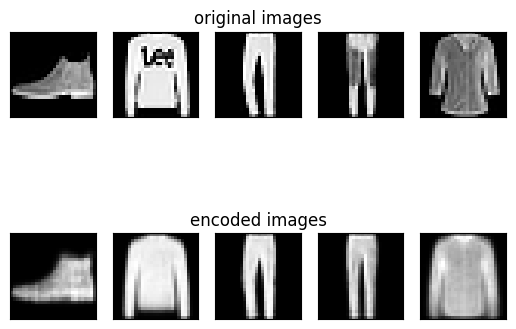

In [43]:
xhat=deep_autoencoder.predict(x_test)
plot_images(x_test,xhat,start=0,stop=5)

### Loading Images From a Directory for Autoencoders

Loading images from a directory for Autoencoders is similar to that for neural networks, but there are also several small differences. Like neural networks we create an object using ```image_dataset_from_directory``` that consists of human faces.


In [44]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/face_data.zip"
# await skillsnetwork.prepare(dataset_url, overwrite=True)

In [45]:
img_height=50
img_width=50
batch_size=100
data_dir_face=os.path.join(os.getcwd(), 'face_data')

In [70]:
Xface = tf.keras.utils.image_dataset_from_directory(
  data_dir_face,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    color_mode="grayscale")


Found 23708 files belonging to 1 classes.
Using 18967 files for training.


In [47]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/face_data.zip

--2025-09-26 19:53:18--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/face_data.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131763644 (126M) [application/zip]
Saving to: ‘face_data.zip’

face_data.zip       100%[===================>] 125.66M  53.5MB/s    in 2.3s    

2025-09-26 19:53:21 (53.5 MB/s) - ‘face_data.zip’ saved [131763644/131763644]



In [48]:
!unzip -q face_data.zip -d /content/

In [49]:
Xface = tf.keras.utils.image_dataset_from_directory(
  data_dir_face,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    color_mode="grayscale")

Found 23708 files belonging to 1 classes.
Using 18967 files for training.


We will copy the object as we will use it multiple times


In [50]:
X_face_copy=copy.copy(Xface)

Unlike neural networks, autoencoders have no labels. Instead, the input and output are both a set of features $\textbf{X}$. Therefore you have to map the output from the directory object from $(\textbf{x},\textbf{y})$ to $(\textbf{x},\textbf{x}$), using the following function:

In [51]:
def change_inputs(images, labels):

    return images, images

To apply the transform to the image, we use the ```apply``` method to apply the function ```change_inputs``` :


In [52]:
X_face_1=Xface.map(change_inputs)

We will convert the object to an iterator so we can cycle through the samples:

In [53]:
X_iter=iter(X_face_1)

We see each output is two tuples, each an array of 100 50x50 images

In [54]:
images1, images2 = next(X_iter)

In [55]:
print("images1 shape {}, and images2 {}".format(images1.shape, images2.shape))

images1 shape (100, 50, 50, 1), and images2 (100, 50, 50, 1)


We can plot some of the images using the function ```display_auto``` where ```n``` is the sample in a batch and ```B``` is the batch number, assuming next has only been called once

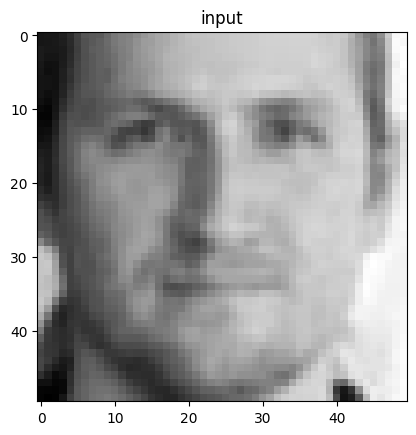

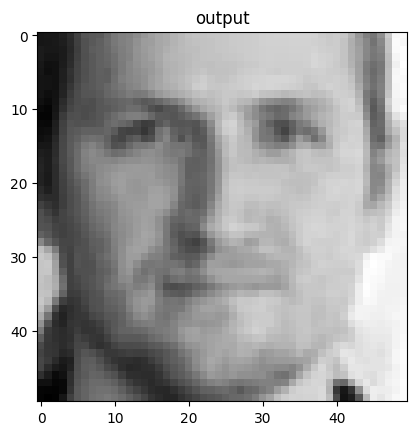

In [56]:
display_auto(X_iter,n=1,B=1)

we can also apply other transformations like normalizing the image

In [57]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In many cases we would like a corrupted version of the image $\textbf{x},\tilde{\textbf{x}}$. Let's construct a from-the-directory object that can be used to train an autoencoder to deblur an image. In many applications like noise removal, you add noise to $\textbf{x}$ and get $\tilde{\textbf{x}}$. In this case, the input  $\tilde{\textbf{x}}$ will be a blurred image.

In [60]:
def blur_image(images, labels, conv_layer):

    x = normalization_layer(images)
    x_b=conv_layer(x)
    return x_b, x

We normalize the image and then blur the image using a filter, we apply the function to the dataset object.


In [65]:
# Remove the blurring step using a_conv from the dataset mapping
# Xface=Xface.map(lambda images, labels: blur_image(images, labels, a_conv), num_parallel_calls=tf.data.AUTOTUNE)

# Revert to the original dataset without the complex blurring map
# We will transform to (image, image) later for the autoencoder
pass

We see the input image is blurred:

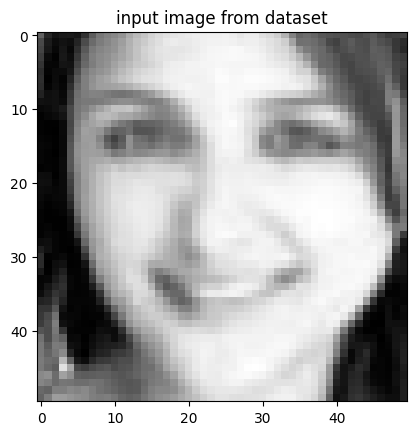

In [71]:
Xiter=iter(Xface)
display_auto(Xiter,n=1,B=1)

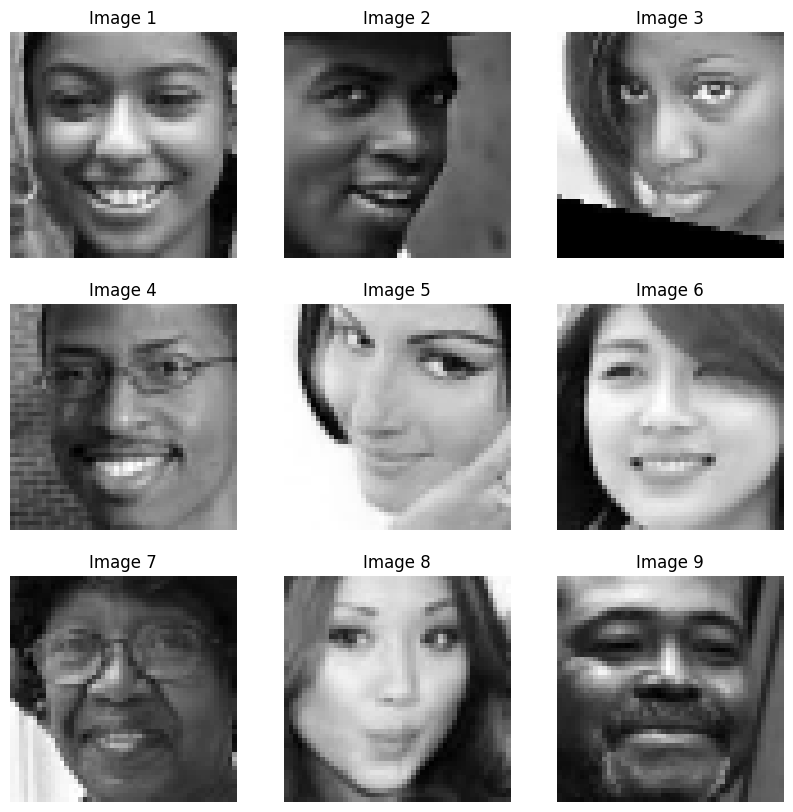

In [72]:
# Get a sample batch from the dataset
for images, labels in Xface.take(1):
    # Display a few images from the batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"Image {i+1}")
        plt.axis("off")
    plt.show()

## Convolutional Autoencoders


Analogous to Convolutional neural networks, there are Convolutional Autoencoders (CAEs). Compared to the Autoencoders with fully connected layers, Convolutional Autoencoders with Conv2D layers do a better job encapsulating the pixel data's underlying patterns.

The following is an illustration of the CAE's architecture:

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/CAE.png" width="80%" style="vertical-align:middle;margin:15px 0px"></center>

Image from [this article](https://ai.plainenglish.io/convolutional-autoencoders-cae-with-tensorflow-97e8d8859cbe?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01).

We can build a convolutional autoencoder class:


In [73]:
class CNN_Autoencoder(Model):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(50, 50, 1)),
            Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
            Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)])

        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
            Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



The encoder consists of several convolution layers that will produce an activation map:

```encoder = tf.keras.Sequential([layers.Input(shape=(50, 50, 1)),Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)])```


The decoder consists of several transposed convolutional or de-convolutional layers; the final layer is a convolutional layer that combines the activation maps of the previous transposed convolutional layer to form an image:

```decoder = tf.keras.Sequential([Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])```


Let's create a ```CNN_Autoencoder``` object

In [74]:
cnn_autoencoder_face=CNN_Autoencoder()

Let's train the CNN autoencoder and use it to de-blur an image by minimizing the difference between $\tilde{\textbf{x}}$ and $\textbf{x}$. Note that for training, we pass in `Xface`, which can be seen as an image data generator that will feed our model pairs of blurred images and original image. We expect the model to learn and minimize the difference between the two and eventually be able to recover the original image from a blurred image.

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 157s 812ms/step - loss: 0.1236
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 200s 802ms/step - loss: 5.7041e-06
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 152s 796ms/step - loss: 6.7191e-07
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 155s 815ms/step - loss: 2.3725e-07
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 200s 804ms/step - loss: 1.1610e-07
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 203s 810ms/step - loss: 7.1267e-08
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 201s 803ms/step - loss: 4.4685e-08
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 154s 809ms/step - loss: 3.1645e-08
Epoch 9/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 154s 811ms/step - loss: 2.2030e-08
Epoch 10/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 154s 812ms/step - loss: 1.6402e-08


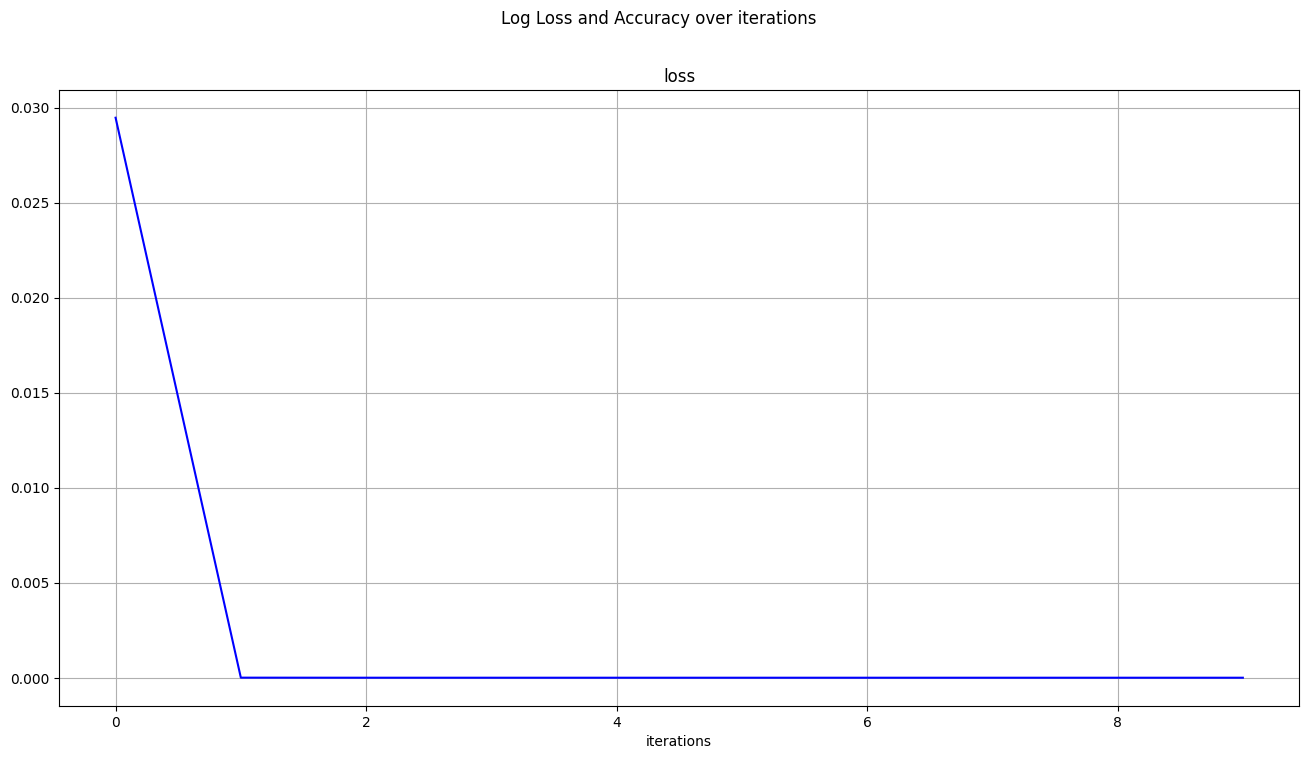

In [75]:
cnn_autoencoder_face.compile(optimizer='adam',  loss='mse')
history=cnn_autoencoder_face.fit(Xface,epochs=10)

graph_history(history, title='Log Loss and Accuracy over iterations')


We take some samples from the set of blurred images and use the trained autoencoder to deblur the images and compare them to the blurred images.

In [76]:
x = next(Xiter)
Xhat=cnn_autoencoder_face.predict(x[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


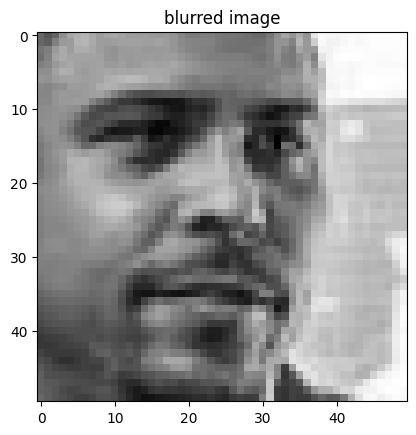

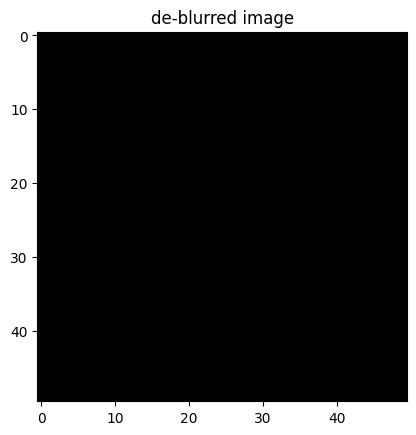

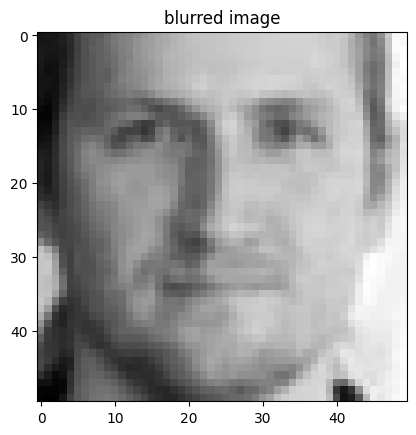

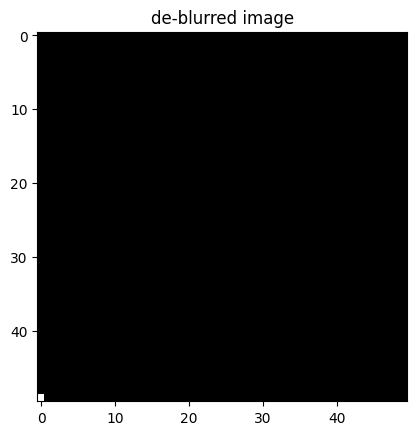

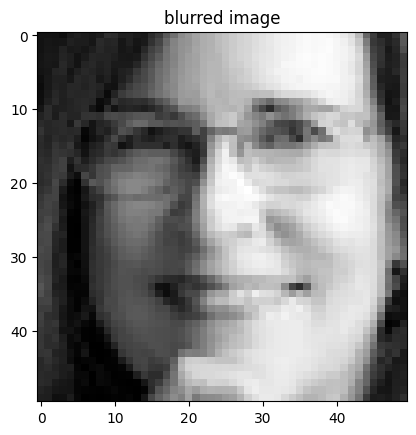

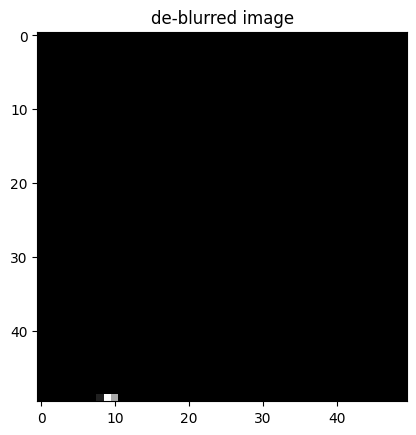

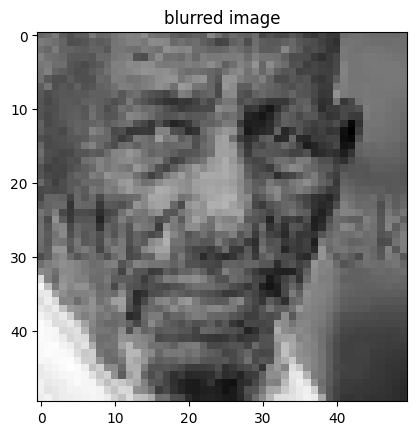

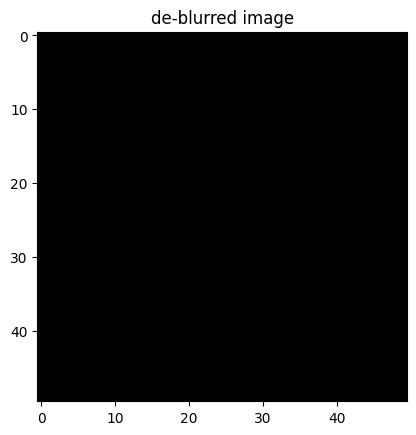

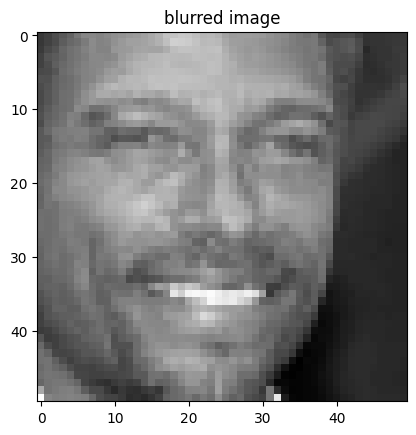

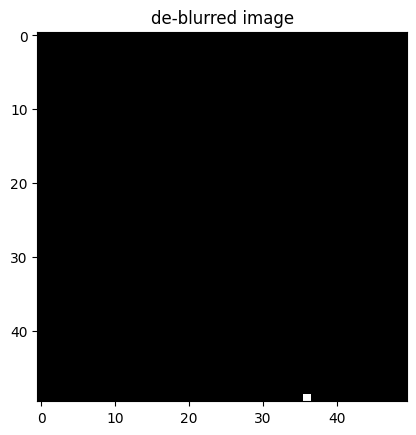

In [77]:
for image_b, image_db in zip(x[0].numpy()[0:5,:,:,0],Xhat[0:5,:,:,0]):
    plt.imshow(image_b, cmap="gray")
    plt.title("blurred image")
    plt.show()
    plt.imshow(image_db, cmap="gray")
    plt.title("de-blurred image")
    plt.show()

We see that as the CNN autoencoder can learn the complex image features well, it can be used to de-blur the blurred images and represent the features more clearly.